In [1]:
from pathlib import Path
import os

import numpy as np
import polars as pl
import matplotlib.pyplot as plt


rootdir = Path(os.getcwd()).parent
figdir = rootdir / Path("fig")
figdir.mkdir(exist_ok=True, parents=True)

pl.Config.set_tbl_cols(20)


YAW = 45


In [2]:
df = pl.read_csv(rootdir / "cache/tsr_pitch_yaw.csv")
df["data_type"].unique().to_numpy()


array(['Ctprime_trajectory', 'contour', 'optimal', 'k-omega',
       'zero_yaw_Ctprime_trajectory', 'constant_tsr'], dtype=object)

## iso-$C_p$/$C_T'$ contours

In [3]:
df_surface_Cp = (
    df.filter(pl.col("data_type") == "contour")
    .filter(pl.col("yaw") == 0)
    .pivot(index="tsr", columns="pitch", values="Cp", aggregate_function=None)
)
df_surface_Cp2 = (
    df.filter(pl.col("data_type") == "contour")
    .filter(pl.col("yaw") == YAW)
    .pivot(index="tsr", columns="pitch", values="Cp", aggregate_function=None)
)


surfaces = {
    "Cp": df_surface_Cp,
    "Cp2": df_surface_Cp2,
}


## Optimal control strategies points


In [4]:
df_global_opt = df.filter(pl.col("data_type") == "optimal").filter(pl.col("yaw") == YAW)
df_k_omega = df.filter(pl.col("data_type") == "k-omega").filter(pl.col("yaw") == YAW)

df_constant_tsr = df.filter(pl.col("data_type") == "optimal").filter(pl.col("yaw") == 0)


strategy_points = {
    "constant_tsr": df_constant_tsr,
    "k_omega": df_k_omega,
    "global_opt": df_global_opt,
    "k_omega0": df_constant_tsr,
    "global_opt0": df_constant_tsr,
}


## Optimal control strategy trajectories

In [5]:
df_min_Ct_zero_yaw = (
    df.filter(pl.col("data_type") == "Ctprime_trajectory")
    .filter(pl.col("yaw") == 0)
    .filter(pl.col("Ctprime") < df_constant_tsr["Ctprime"])
)
df_min_Ct = (
    df.filter(pl.col("data_type") == "Ctprime_trajectory")
    .filter(pl.col("yaw") == YAW)
    .filter(pl.col("Ctprime") < df_global_opt["Ctprime"])
)

df_optimal_trajectory = df.filter(pl.col("data_type") == "optimal").filter(
    pl.col("yaw") < YAW
)
df_k_omega_trajectory = df.filter(pl.col("data_type") == "k-omega").filter(
    pl.col("yaw") < YAW
)
df.filter(pl.col("data_type") == "k-omega_optimal").filter(pl.col("yaw") < YAW)

strategy_trajectories = {
    "zero_yaw_Ct_min": df_min_Ct_zero_yaw,
    f"Ct_min": df_min_Ct,
    "optimal_traj": df_optimal_trajectory,
    "k_omega_traj": df_k_omega_trajectory,
}


### Define plotting parameter dictionaries

In [6]:
strategy_labels = {
    "global_opt": "Global optimal",
    "k_omega": "$K-\Omega^2$",
    "global_opt0": "Global optimal",
    "k_omega0": "$K-\Omega^2$",
    # "constant_tsr": "Constant $\lambda$",
    "constant_tsr": "zero-yaw optimal",
}
strategy_style = {
    "global_opt": "*",
    "k_omega": "P",
    "global_opt0": "*",
    "k_omega0": "P",
    "constant_tsr": "o",
}
strategy_color = {
    "global_opt": "lime",
    "k_omega": "blue",
    "global_opt0": "lime",
    "k_omega0": "blue",
    "constant_tsr": "tab:orange",
}
strategy_ms = {
    "global_opt": 10,
    "k_omega": 15,
    "global_opt0": 10,
    "k_omega0": 15,
    "constant_tsr": 15,
}


trajectory_labels = {
    "zero_yaw_Ct_min": "min $C_T$ ($\gamma=0°$)",
    "Ct_min": f"min $C_T$ ($\gamma={YAW}°$)",
    "optimal_traj": None,
    "k_omega_traj": None,
}

trajectory_style = {
    "zero_yaw_Ct_min": "-",
    "Ct_min": f"-",
    "optimal_traj": ":",
    "k_omega_traj": ":",
}

trajectory_color = {
    "zero_yaw_Ct_min": "tab:orange",
    "Ct_min": "lime",
    "optimal_traj": "0.2",
    "k_omega_traj": "0.2",
}


## Plot derate strategies

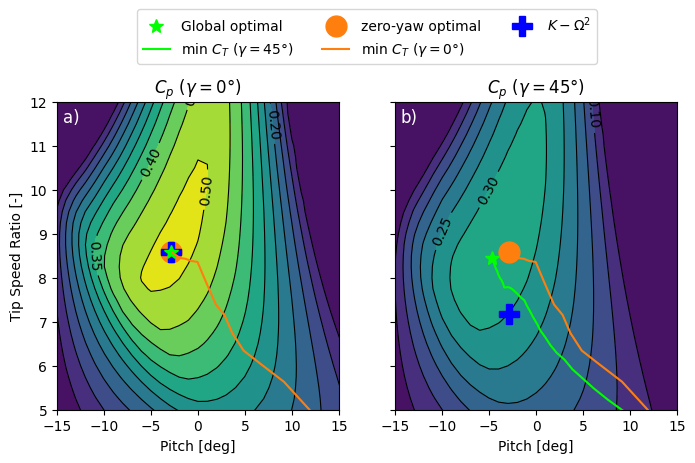

In [7]:
cmaps = {
    "Cp": "viridis",
    "Cp2": "viridis",
}
surface_label = {
    "Cp": "$C_p$ ($\gamma=0$°)",
    "Cp2": "$C_p$ ($\gamma=45$°)",
}
levels = {
    "Cp": np.arange(0, 0.60, 0.05),
    "Cp2": np.arange(0, 0.60, 0.05),
}

to_show = {
    "Cp": ["k_omega0", "global_opt0", "constant_tsr", "zero_yaw_Ct_min"],
    "Cp2": ["global_opt", "k_omega", "constant_tsr", "zero_yaw_Ct_min", "Ct_min"],
}

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8, 4))

[ax.set_xlabel("Pitch [deg]") for ax in axes]
axes[0].set_ylabel("Tip Speed Ratio [-]")

plt.xlim(-15, 15)
plt.ylim(5, 12)

for ax, (key, df_surface) in zip(axes, surfaces.items()):
    # Plot surface
    tsr = df_surface["tsr"].to_numpy()
    pitch = np.array(df_surface.columns[1:], dtype=float)
    Z = df_surface.to_numpy()[:, 1:]
    Z[Z < 0] = 0.01

    ax.set_title(surface_label[key])

    ax.contourf(pitch, tsr, Z, levels=levels[key], cmap=cmaps[key])
    CS = ax.contour(pitch, tsr, Z, levels=levels[key], colors="k", linewidths=0.8)
    ax.clabel(CS, inline=True, fontsize=10)

    # Plot strategy points
    for strat_key, data in strategy_points.items():
        if strat_key not in to_show[key]:
            continue

        ax.plot(
            data["pitch"],
            data["tsr"],
            strategy_style[strat_key],
            color=strategy_color[strat_key],
            label=strategy_labels[strat_key],
            ms=strategy_ms[strat_key],
        )

    # Plot strategy trajectories
    for traj_key, data in strategy_trajectories.items():
        if traj_key not in to_show[key]:
            continue
        ax.plot(
            data["pitch"],
            data["tsr"],
            trajectory_style[traj_key],
            color=trajectory_color[traj_key],
            label=trajectory_labels[traj_key],
        )

# Legend, including reordering so lines are at bottom
handles, labels = axes[1].get_legend_handles_labels()
order = [2, 4, 0, 3, 1]
axes[1].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(-0.1, 1.1),
)


# Titles (as text)
axes[0].text(
    0.02,
    0.98,
    "a)",
    fontsize=12,
    color="w",
    ha="left",
    va="top",
    transform=axes[0].transAxes,
)
axes[1].text(
    0.02,
    0.98,
    "b)",
    fontsize=12,
    color="w",
    ha="left",
    va="top",
    transform=axes[1].transAxes,
)


plt.savefig(
    figdir / "Cp_Ctprime_surface_trajectories.png", dpi=300, bbox_inches="tight"
)
